In [1]:
import flax, jax, optax
from flax import linen as nn
from torch.utils.data import Dataset,DataLoader
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
rng = jax.random.PRNGKey(42)

In [2]:
class SimpleClassifier(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    def setup(self):
        self.linear1 = nn.Dense(features=self.num_hidden)
        self.linear2 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        x = self.linear1(x)
        x = nn.tanh(x)
        x = self.linear2(x)
        return x

In [3]:
class SimpleClassifierCompact(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        # while defining necessary layers
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [4]:
model = SimpleClassifier(num_hidden=8, num_outputs=1)
# Printing the model shows its attributes
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


In [5]:
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8, 2))  # Batch size 8, input size 2
# Initialize the model
params = model.init(init_rng, inp)
print(params)

FrozenDict({
    params: {
        linear1: {
            kernel: DeviceArray([[ 0.5564613 ,  0.9367376 ,  0.2285179 , -0.23255277,
                          -0.25101846, -0.48948383,  0.11607227,  0.40487856],
                         [-0.3619682 ,  0.9271343 ,  0.6478837 ,  0.26224074,
                           0.34578732,  1.1132734 ,  0.06098709,  0.49297702]],            dtype=float32),
            bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
        },
        linear2: {
            kernel: DeviceArray([[ 0.4818003 ],
                         [-0.35573798],
                         [-0.62196773],
                         [ 0.28606406],
                         [-0.79486924],
                         [ 0.5573447 ],
                         [-0.1400483 ],
                         [ 0.41512278]], dtype=float32),
            bias: DeviceArray([0.], dtype=float32),
        },
    },
})


In [6]:
model.apply(params, inp)

DeviceArray([[ 0.13819844],
             [ 0.6173139 ],
             [-0.19211891],
             [ 0.00855249],
             [ 0.12030913],
             [-0.34759673],
             [ 0.07192342],
             [ 0.11894515]], dtype=float32)

In [7]:


class XORDataset(Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label



In [8]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), 1)


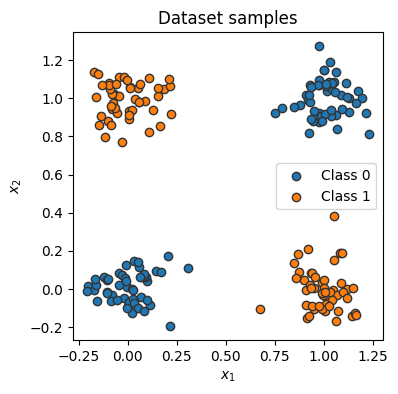

In [9]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

visualize_samples(dataset.data, dataset.label)
plt.show()



In [10]:
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = DataLoader(dataset, batch_size=8, shuffle=True,collate_fn=numpy_collate)

In [11]:
data_inputs, data_labels = next(iter(data_loader))

In [12]:
data_inputs

array([[ 0.97765374,  1.0714    ],
       [ 1.1305479 ,  1.0021003 ],
       [ 1.0259722 , -0.09043166],
       [ 1.0872321 ,  1.0183342 ],
       [ 0.9181779 ,  0.20923872],
       [ 0.0332314 , -0.07484865],
       [ 0.1551152 ,  1.0115675 ],
       [ 0.9887672 , -0.02209696]], dtype=float32)

In [13]:
optimizer = optax.sgd(learning_rate=0.1)

In [14]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [15]:
def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

In [16]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(DeviceArray(0.76251626, dtype=float32), DeviceArray(0.25, dtype=float32))

In [17]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=True  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc

@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

In [18]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

In [19]:
def train_model(state, data_loader, num_epochs=100):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
    return state

In [20]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
trained_model_state

TrainState(step=DeviceArray(2000, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)>, params=FrozenDict({
    params: {
        linear1: {
            bias: DeviceArray([-0.47993064, -0.3740395 , -0.73164797,  0.17162552,
                          0.5236606 , -1.0187862 , -0.29728273, -0.4478788 ],            dtype=float32),
            kernel: DeviceArray([[ 1.344643  ,  1.9636216 ,  0.11960107, -0.87495375,
                          -1.5308924 , -3.288449  ,  0.36382312,  2.0547054 ],
                         [-2.2055743 ,  2.032762  ,  1.2385111 ,  0.1453398 ,
                           2.4737673 ,  2.5148292 ,  0.21845788,  2.1377044 ]],            dtype=float32),
        },
        linear2: {
            bias: DeviceArray([0.6713965], dtype=float32),
            kernel: DeviceArray([[ 2.1709273 ],
                         [ 2.4324908 ],
                         [-1.5124226 ],
           

In [22]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [24]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)
eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


In [25]:
trained_model = model.bind(trained_model_state.params)
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
out.shape



(8, 1)

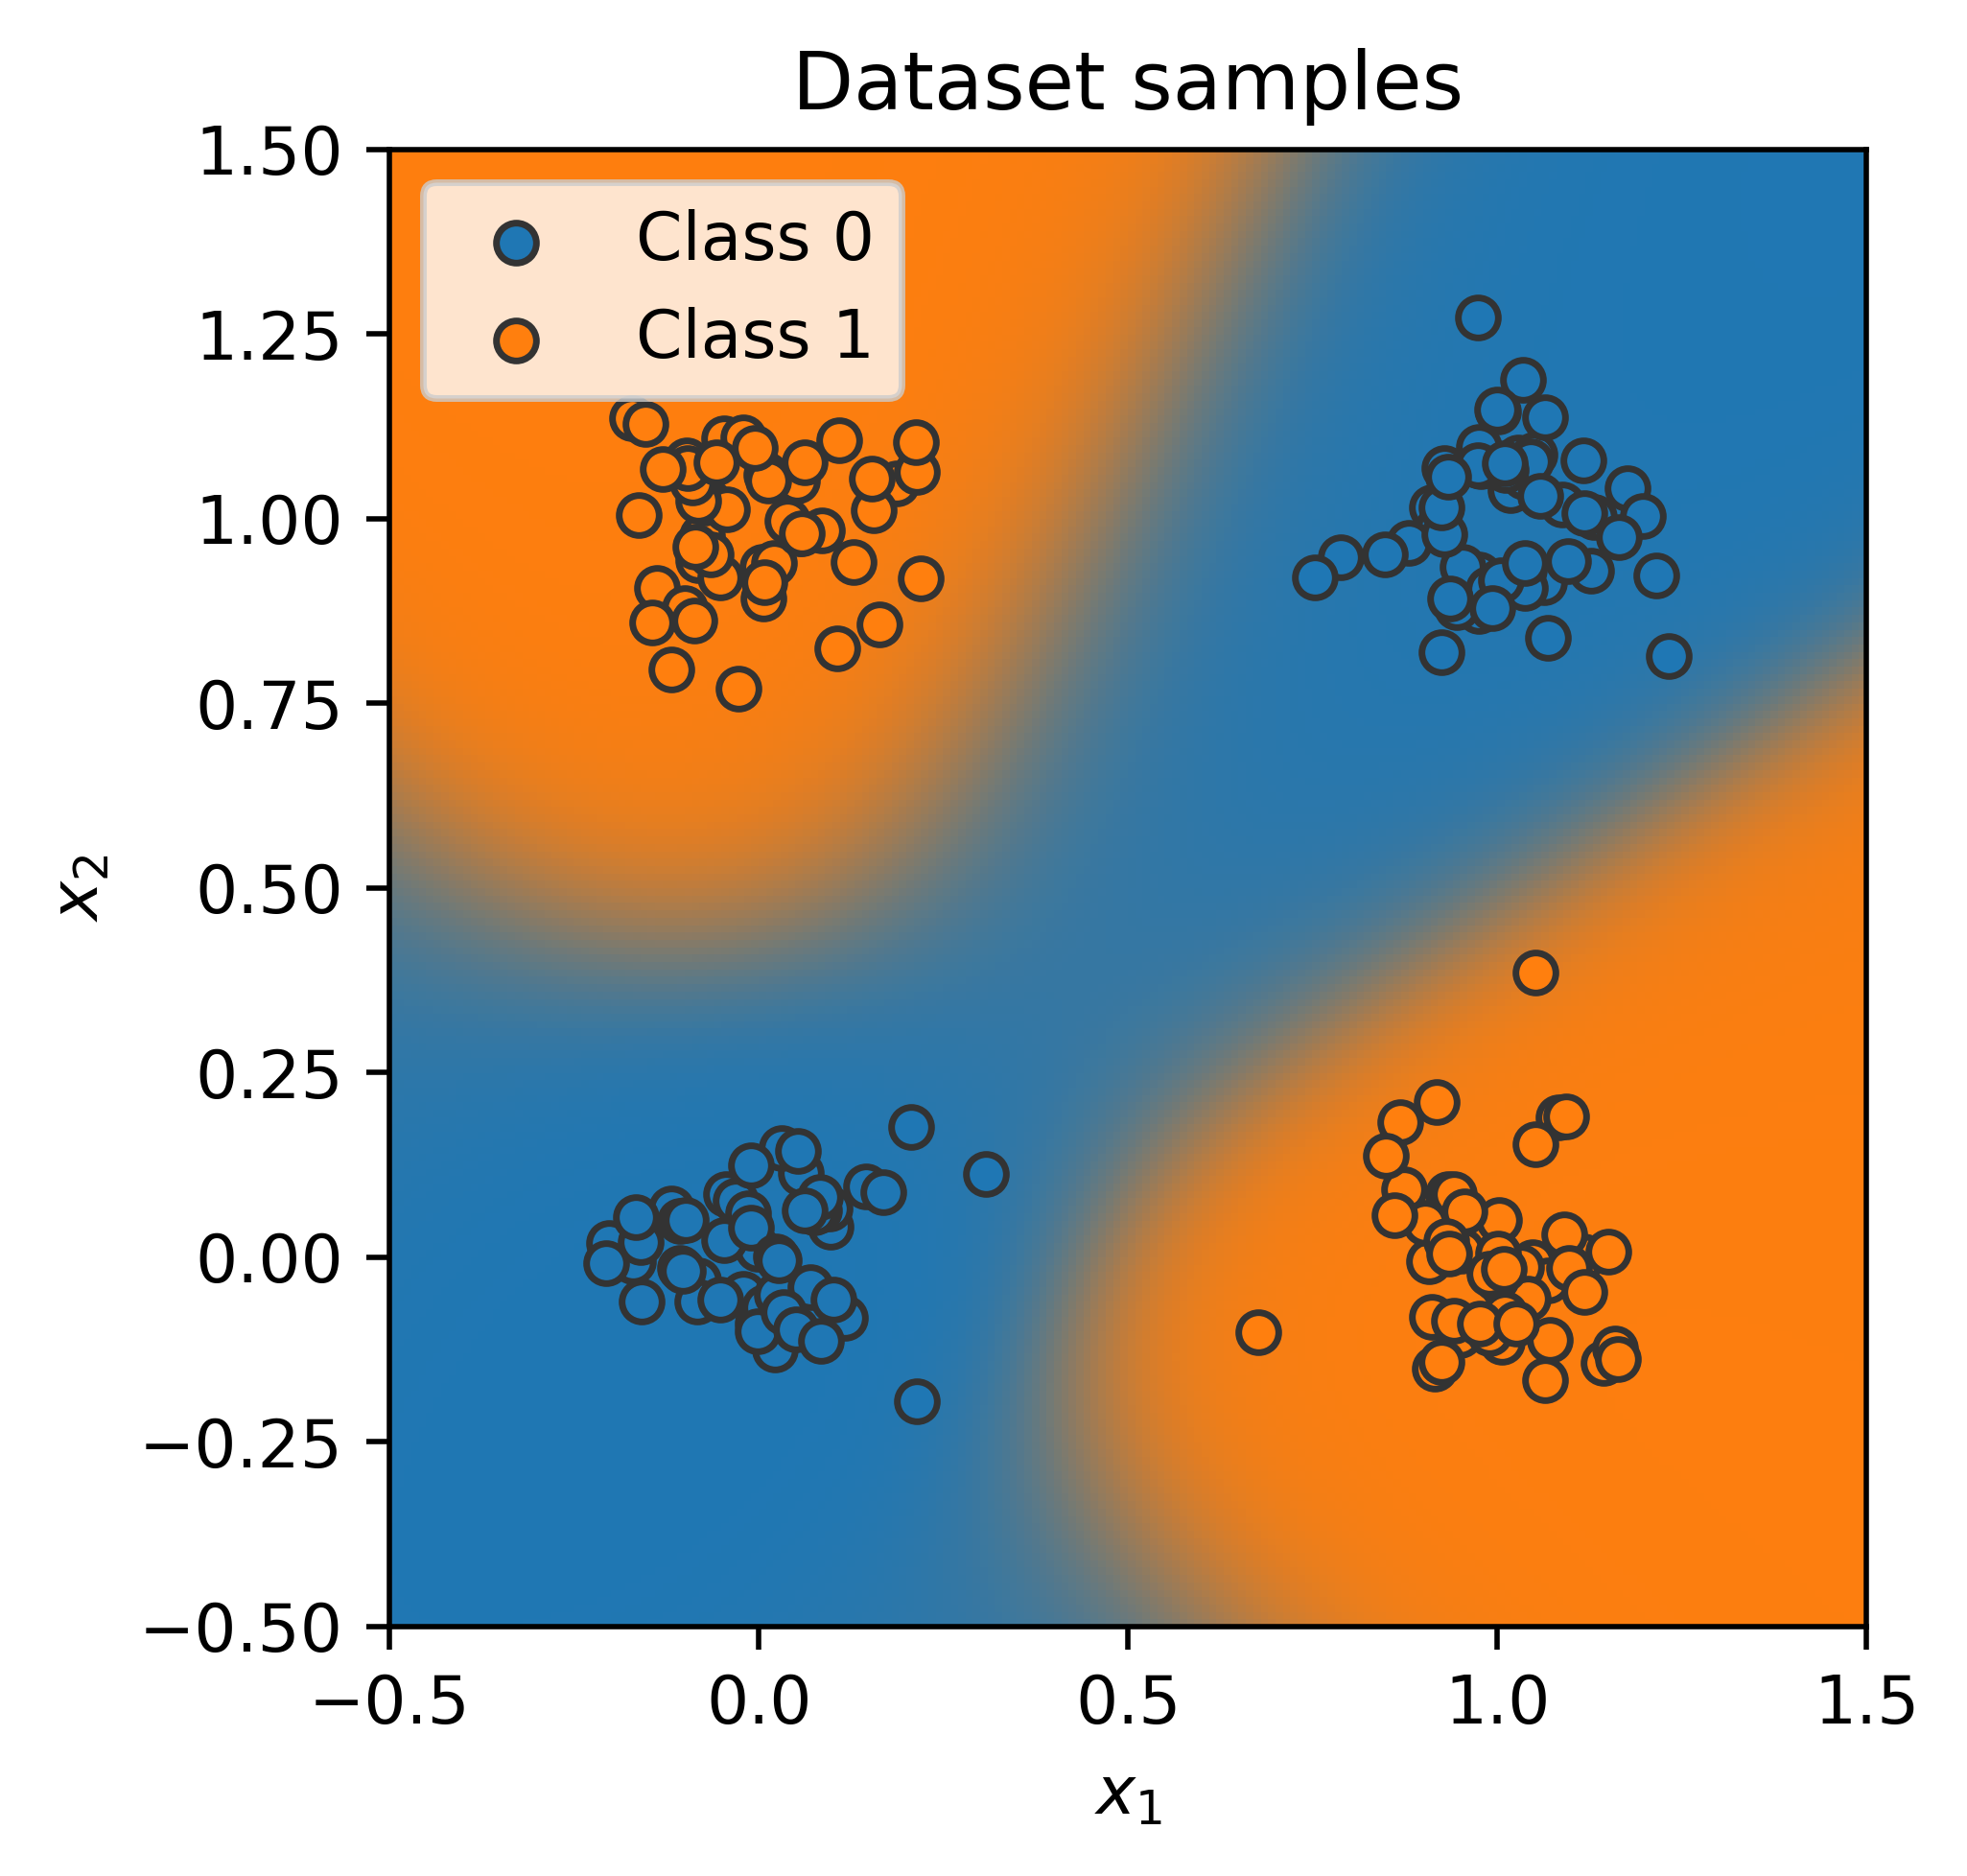

In [27]:
from matplotlib.colors import to_rgba
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()